# Kaggle Titanic with Linear Regression and Neural Network
*without any Machine Learning framework! (TensorFlow, PyTorch, etc.)*

# About

This notebook and the efforts behind this are heavily inspired by [Prof. Jeremy Howard](https://twitter.com/jeremyphoward) and the [FastAI community](https://forums.fast.ai/c/p1v5/54)!

In lesson 3 of Part 1 of the v2022 course, Prof. Howard takes us on a ride where he explains Machine Learning in a very simple and 
intuitive way. The theme of the lesson (unlike others) is no-code. We understand linear regression and Neural Nets
from scratch by simple operations in Microsoft Excel. 

To understand thoroughly, I tried my hand at replicating what Jeremy did in the lecture – in excel. As I tried to implement it, I realized that Python is way more intuitive ***for me*** and I will learn more if I do this in Python than in excel. I am not much familiar with Excel and doing it in Python seemed like a good learning exercise. 

I had to figure out a few things along the way. Getting the dimensions of the matrices right and handling NumPy arrays was a pain but worth the try. Ultimately, I believe I have implemented the Lesson 3 excel file of the Kaggle Titanic dataset here in Python. 

A quick note about structure: 
- This notebook is a walkthrough and written with the intent to have every functionality that Jeremy has introduced in Lesson 3. 
- I did not want to take the help of any off-the-shelf Machine Learning frameworks so we build everything from scratch. Only Pandas and Numpy are used here. 
- Even for the solver, we build Gradient Decent from scratch with NumPy and import it here. 
- Feel free to look at `solver.py` in the repository (in `./supporting_files/2022-11-01-FastAI-Lesson3-Titanic-Python` directory). 
    - It has linear regression and deep learning versions of Gradient Decent algorithms. 
    - Any comments/suggestions are super welcome!
    
*Note*: We implement this with Matrix multiplication logic which Jeremy explained in the latter part of the lecture. 

### Step1: Let's improt libraries – pandas and numpy and have our solvers ready. 

In [1]:
# hide
import sys
import os
THIS_FILE_DIR_PATH = os.getcwd()
supporting_files_dir = os.path.join(THIS_FILE_DIR_PATH, "supporting_files", "2022-11-01-FastAI-Lesson3-Titanic-Python")
sys.path.append(supporting_files_dir)

In [2]:
import pandas as pd
import numpy as np
from solver import gradient_decent, gradient_decent_nn

In [3]:
TRAIN_FILE_PATH = os.path.join(supporting_files_dir, "titanic", "train.csv")
ITERATIONS = 80

In [4]:
def load_data(file_path):
    """
    loads csv and returns the dataframe
    """
    df = pd.read_csv(file_path)
    return df

### Step 2: Let's load the data, and observe the columns

In [5]:
df = load_data(file_path=TRAIN_FILE_PATH)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Step 3: We'll follow lecture 3 as close as possible. 

Here, we'll scoop only the columns that Jeremy has used in the lecture. We will also enrich our data-frame with the same logic as the lecture. We will prepare new columns for class, embarked, fare, and male/female. 

*Note*: The overall flow and even the column names are kept the same as in the excel file. We replace `Ones` column with `Const` in dataframe so that it alights with `Const` feature in the features list.

In [6]:
nec_cols = ["Survived", "Embarked", "Pclass", "Sex", "Age", "Fare", "SibSp", "Parch"]
df_nec = df[nec_cols]
df_nec.columns

Index(['Survived', 'Embarked', 'Pclass', 'Sex', 'Age', 'Fare', 'SibSp',
       'Parch'],
      dtype='object')

In [7]:
# hide
df_nec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Embarked  889 non-null    object 
 2   Pclass    891 non-null    int64  
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   Fare      891 non-null    float64
 6   SibSp     891 non-null    int64  
 7   Parch     891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Same as the lecture, since many rows are empty, we'll only get non-empty rows. We get around 712 rows of data. 

In [8]:
df_nec = df_nec.dropna(how='any',axis=0) 

Now we need to enrich our dataframe i.e. make new features based on the data. 

Per the lecture, we follow new columns for features: Pclass, Embark, Age, and Fare. Let's apply similar logic and transformation

In [9]:
# Age & Fare columns transform
max_age = df_nec["Age"].max()
print(f"Max age is: {max_age}")

df_nec["Age_N"] = df_nec["Age"] / max_age
df_nec["log_Fare"] = np.log10(df_nec["Fare"]+1)

# Pclass_1 & Pclass_2
df_nec["Pclass_1"] = (df_nec["Pclass"] == 1).astype(int)
df_nec["Pclass_2"] = (df_nec["Pclass"] == 2).astype(int)

# Embark_S and Embark_C
df_nec["Embark_S"] = (df_nec["Embarked"] == "S").astype(int)
df_nec["Embark_C"] = (df_nec["Embarked"] == "C").astype(int)

# Male
df_nec["Male"] = (df_nec["Sex"] == "male").astype(int)

df_nec["Const"] = 1

Y = df_nec["Survived"].values.reshape(len(df_nec),1)
# df_nec.columns

Max age is: 80.0


### Step 4: Initialize the weights
Now that we have our data ready, we initialize the weights randomly. Columns `R-AA` in excel sheet. 

In [10]:
params_features = ["SibSp", "Parch", "Age_N", "log_Fare", "Pclass_1", "Pclass_2", "Embark_S", \
    "Embark_C", "Male", "Const"]
df_nec_num = df_nec[params_features]
np.random.seed(0)
rand_initializers = np.random.uniform(low=0, high=1, size=(len(params_features), 1)).round(2)

In [11]:
rand_initializers

array([[0.55],
       [0.72],
       [0.6 ],
       [0.54],
       [0.42],
       [0.65],
       [0.44],
       [0.89],
       [0.96],
       [0.38]])

In [12]:
# hide
# now we build the model and loss function
# prediction_1_n = w_SibSp*SibSp_1 + w_Parch*Parch_1 + w_Age_N*Age_N_1 + w_log_Fare * log_Fare_1 + \
#     w_Pclass_1 * Pclass_1_1 + w_Pclass_2 * Pclass_2_1 + w_Embark_S + Embark_S_1 + w_Embark_C + Embark_C_1 + \
#         w_Male * Male_1 + w_Const * Const_1
# Now, 
# we need to compute predictions for all example

In [13]:
# hide
# preds = compute_model_output(X=df_nec_num, W=rand_initializers).values.reshape(len(df_nec), 1)
# Y = df_nec["Survived"].values.reshape(len(df_nec),1)

### Step 5: Cost and Prediction walkthrough (Linear Regression)

Cost and Prediction functions are defined in the following cells for understanding. These are used for calculating cost and predictions of our model. 

For cost, we take the `sum` as opposed to `average` in the excel file. 


In [14]:
def compute_cost(predictions, Y):
    """
    calculate cost based on two column vectors of size n x 1
    """
    m = len(Y)
    cost_per_datapoint = np.subtract(predictions, Y)**2
    total_cost = sum(cost_per_datapoint)
    # total_cost = sum(cost_per_datapoint/(2*m))
    return total_cost

def compute_model_output(X, W):
    # model: X*W 
        # W = n x 1, 
        # X = n x m
        # n: number of features (weights) + constant term
        # m: number of training examples
    
    # output: predictions (n x 1)
    
    return np.matmul(X, W)

### Step 6: Use above functions and optimize the weights. (Linear Regression)

We optimize the weights from random numbers with an ojective to minimize loss/cost defined above. 

In [15]:
weights, costs = gradient_decent(iterations=ITERATIONS, W=rand_initializers, X=df_nec_num, Y=Y, alpha=0.1)

Iteration # 0, cost: [6936.00736642]
Iteration # 8, cost: [298.12898267]
Iteration # 16, cost: [250.16788143]
Iteration # 24, cost: [216.89097022]
Iteration # 32, cost: [192.44287041]
Iteration # 40, cost: [174.63487796]
Iteration # 48, cost: [160.97752133]
Iteration # 56, cost: [150.915957]
Iteration # 64, cost: [143.19206508]
Iteration # 72, cost: [137.17995749]


### Step 7: Neural Network implementation 

Note that we only implement the Neural Network as shown in the lecture and this is purely for understanding purposes. There is a possibility that production Neural Nets work in a slightly polished/refined way. The underlying components remain the same. 

For neural nets, we do the following computes: 
- We calculate linear regression twice with a different set of randomly initialized feature weights. 
- Then we apply ReLU – which is where we replace negative values in our predictions with zero. 
- Finally, we add these two individual predictions up and call Neural Network predictions. 

Following is the function we use for calculating the predictions of a Nural Network. Logic follows the excel file and lecture 3. 

In [16]:
def compute_model_output_nn(X, W):
    # model: X*W 
        # W = n x 1, 
        # X = n x m
        # n: number of features (weights) + constant term
        # m: number of training examples
    
    # output: predictions (n x 1)
    
    linear_preds = np.matmul(X, W) 
    # this returns the matrix of dimentions (n x 2). Each column as separate linear regression prediction. 
    
    # now, we apply ReLU to the predictions
    lin_relu_preds = np.where(linear_preds < 0, 0, linear_preds) # make negative values zero

    # now, we take sum of these two predictions 
    return np.sum(lin_relu_preds, axis=1) # sum 

In [17]:
np.random.seed(0)
rand_initializers_dl = np.random.uniform(low=0, high=1, size=(len(params_features), 2)).round(2)

In [18]:
weights_dl, costs_dl = gradient_decent_nn(iterations=ITERATIONS, W=rand_initializers_dl, X=df_nec_num, Y=Y, alpha=0.1)

Iteration # 0, cost: [37825.41313583]
Iteration # 8, cost: [228.30451932]
Iteration # 16, cost: [184.92278215]
Iteration # 24, cost: [159.92333415]
Iteration # 32, cost: [145.00889701]
Iteration # 40, cost: [135.83319126]
Iteration # 48, cost: [130.18663049]
Iteration # 56, cost: [126.39428926]
Iteration # 64, cost: [123.72175152]
Iteration # 72, cost: [121.67674539]


### Step 8: [Optional] Try to intuitively understand efficiency of learning.

Here we try to make sense of Linear Regression vs. Neural Network algorithms costs after training them with the same number of pre-defined iterations. 

We plot the *Loss vs. Training Iterations* graph of both Linear Regression and Neural Network algorithms. It's evident that Neural Network learns more effectively and has consistently lower loss as opposed to the Linear Regression algorithm. 

This highlights the beauty of Neural Nets where they represent the data more effectively. 

*Note*: The Y axis of the graph is in the log scale. 
As Jeremy mentioned: "The Log scale makes really big numbers small and does not change small numbers much so it's easier to understand in certain cases."

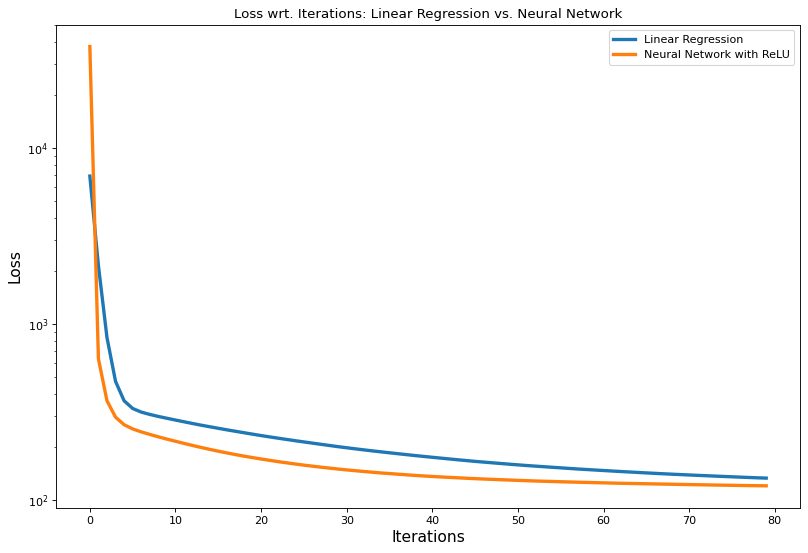

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(12, 8), dpi=80)

plt.plot(costs, lw=3)
plt.plot(costs_dl, lw=3)
plt.yscale('log')
plt.legend(['Linear Regression', 'Neural Network with ReLU'], loc='upper right')
plt.title('Loss wrt. Iterations: Linear Regression vs. Neural Network')
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()
